# How to use basicExp.ipynb?

- Enter **mode** name
  > mode = "model name"
- Enter the training epoch of **poisoned/clean** model
  > p = "epoch num" <br>
  > c = "epoch mum"

I already trained some model, which can directly used
|mode name|p and c (epoch number)|
|---|---|
|MNIST|5, 10, 20|
|GTSRB|10, 20, 30, 40, 50|
|CIFAR10|20, 30, 35, 40, 50|
|CIFAR100|100|
|Fashion|5, 10, 15, 30|

Then it will use original test image and noise image to test the **poisoned/clean** model<br>

In [1]:
mode = "CIFAR10"
p = "50"
c = "50"

In [2]:
# ===================================
# This is the import part
# ===================================
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch.autograd import Variable
from torchvision.utils import save_image
import torch.nn.functional as F
from PIL import Image
import pandas as pd
import cv2
# import matplotlib as plt
from matplotlib import pyplot as plt
from collections import Counter

import databackdoor.gtsrbData as gtsrbData
import databackdoor.mnistData as mnistData
import databackdoor.cifar10Data as cifar10Data
import databackdoor.fashionData as fashionData
import databackdoor.cifar100Data as cifar100Data

# =====================================
# define the hook function
# =====================================
global maxList
maxList = []

def get_max_index(model, input, output):
    A = output[0].cpu().detach().numpy()
    maxList.append(np.argmax(A))

def pre_get_max_index(model, input):
    A = input[0].cpu().detach().numpy()
    maxList.append(np.argmax(A))

def get_max_cov(model, input, output):
    A = output[0].cpu().detach().numpy()
    maxList.append(np.max(A))

def pre_get_max_cov(model, input):
    A = input[0].cpu().detach().numpy()
    maxList.append(np.max(A))


global activationData
activationData = []

def activation_data_cov(model, input, output):
    print("+++++++++++++++++++++++++++++++")

    A = output[0].cpu().detach().numpy()
    A = A.ravel()

    activationData.append(A)

def pre_activation_data_cov(model, input):
    print("+++++++++++++++++++++++++++++++A")

    A = input[0].cpu().detach().numpy()
    A = A.ravel()

    activationData.append(A)

def activation_data(model, input, output):
    print("+++++++++++++++++++++++++++++++")

    A = output[0].cpu().detach().numpy()

    plt.title("The activation")
    plt.xlabel("index")
    plt.ylabel("value")
    X, = plt.plot(A)
    plt.legend([X], ["Activation"])
    plt.rcParams["figure.figsize"] = (10, 5)
    plt.show()

def pre_activation_data(model, input):
    print("+++++++++++++++++++++++++++++++")

    A = input[0].cpu().detach().numpy()

    plt.title("The activation")
    plt.xlabel("index")
    plt.ylabel("value")
    X, = plt.plot(A)
    plt.legend([X], ["Activation"])
    plt.rcParams["figure.figsize"] = (10, 5)
    plt.show()

# =====================================
def show_image():
    plt.figure(figsize=(20, 10))
    plt.figure(1)

    ax1 = plt.subplot(211)
    ax1.set_title("The argmax(ReLU) of poisoned model")
    ax1.set_xlabel("index")
    ax1.set_ylabel("value")
    X, = ax1.plot(activationData[0])
    ax1.legend([X], ["Activation"])

    ax2 = plt.subplot(212)
    ax2.set_title("The argmax(ReLU) of clean model")
    ax2.set_xlabel("index")
    ax2.set_ylabel("value")
    Y, = ax2.plot(activationData[1])
    ax2.legend([Y], ["Activation"])

    plt.show()

# =====================================
# The transformation which used to pre-process the data
# The transformation parameter is from: https://github.com/kuangliu/pytorch-cifar 
# =====================================
GTSRBtransform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.3403, 0.3121, 0.3214),
                            (0.2724, 0.2608, 0.2669))
    ])

CIFARtransform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    
# =====================================
# Set the device, if cuda is available, use it, else use cpu
# =====================================
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu")

# =====================================
# Set the mode and load different model para and dataset
# =====================================
if mode == "MNIST":
    poisonedModel = mnistData.NeuralNetwork().to(device)
    poisonedModel.load_state_dict(torch.load(f"./model/MNIST_poisoned{p}.pth"))
    # poisonedModel.load_state_dict(torch.load("./model/test.pth"))
    cleanModel = mnistData.NeuralNetwork().to(device)
    cleanModel.load_state_dict(torch.load(f"./model/MNIST_para{c}.pth"))

    noiseData= mnistData.customDataset(annotations="data/noise/MNIST.csv", img_dir="data/noise/MNIST", transform=transforms.ToTensor(), flag="test")
    NoiseData = DataLoader(dataset=noiseData, batch_size=1, shuffle=True)

    test_dataset = datasets.MNIST(root="data/", train=False, transform=transforms.ToTensor(), download=True)
    cleanData = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
    testData= mnistData.customDataset(annotations="data/PoisonedMNIST/label.csv", img_dir="data/PoisonedMNIST/test", transform=transforms.ToTensor(), flag="train")
    poisonedData = DataLoader(dataset=testData, batch_size=1, shuffle=True)

    torch.no_grad()
    poisonedModel.eval()
    cleanModel.eval()

    handle = poisonedModel.conv1[2].register_forward_hook(get_max_cov)
    handle_standard = cleanModel.conv1[2].register_forward_hook(get_max_cov)

elif mode == "GTSRB":
    poisonedModel = gtsrbData.NeuralNetwork().to(device)
    poisonedModel.load_state_dict(torch.load(f"./model/GTSRB_poisoned{p}.pth"))
    # poisonedModel = gtsrbData.NeuralNetwork().to(device)
    # poisonedModel.load_state_dict(torch.load("./model/test.pth"))
    cleanModel = gtsrbData.NeuralNetwork().to(device)
    cleanModel.load_state_dict(torch.load(f"./model/GTSRB_para{c}.pth"))

    noiseData= gtsrbData.customDataset(annotations="data/noise/GTSRB.csv", img_dir="data/noise/GTSRB", transform=GTSRBtransform, flag="test")
    NoiseData = DataLoader(dataset=noiseData, batch_size=1, shuffle=True)

    test_dataset = datasets.GTSRB(root="data/", split="test", transform=GTSRBtransform, download=True)
    cleanData = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
    testData= gtsrbData.customDataset(annotations="data/PoisonedGTSRB/testlabel.csv", img_dir="data/PoisonedGTSRB/test", transform=GTSRBtransform, flag="test")
    poisonedData = DataLoader(dataset=testData, batch_size=1, shuffle=True)

    torch.no_grad()
    poisonedModel.eval()
    cleanModel.eval()


    handle = poisonedModel.localization[2].register_forward_hook(get_max_cov)
    handle_standard = cleanModel.localization[2].register_forward_hook(get_max_cov)

elif mode == "CIFAR10":
    # poisonedModel = cifar10Data.ResNet(cifar10Data.BasicBlock, [2, 2, 2, 2]).to(device)
    poisonedModel = cifar10Data.ResNet18().to(device)
    poisonedModel.load_state_dict(torch.load(f"./model/CIFAR10_poisoned{p}.pth"))
    # cleanModel = cifar10Data.ResNet(cifar10Data.BasicBlock, [2, 2, 2, 2]).to(device)
    cleanModel = cifar10Data.ResNet18().to(device)
    cleanModel.load_state_dict(torch.load(f"./model/CIFAR10_para{c}.pth"))

    # same size with GTSRB
    noiseData= gtsrbData.customDataset(annotations="data/noise/GTSRB.csv", img_dir="data/noise/GTSRB", transform=CIFARtransform, flag="test")
    NoiseData = DataLoader(dataset=noiseData, batch_size=1, shuffle=True)

    test_dataset = datasets.CIFAR10(root="data/", train=False, transform=CIFARtransform, download=True)
    cleanData = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
    testData= gtsrbData.customDataset(annotations="data/PoisonedCIFAR10/testlabel.csv", img_dir="data/PoisonedCIFAR10/test", transform=CIFARtransform, flag="test")
    poisonedData = DataLoader(dataset=testData, batch_size=1, shuffle=True)
    
    torch.no_grad()
    poisonedModel.eval()
    cleanModel.eval()

    handle = poisonedModel.layer1.register_forward_pre_hook(pre_get_max_cov)
    handle_standard = cleanModel.layer1.register_forward_pre_hook(pre_get_max_cov)

elif mode == "Fashion":
    poisonedModel = fashionData.NeuralNetwork().to(device)
    poisonedModel.load_state_dict(torch.load(f"./model/FashionMNIST_poisoned{p}.pth"))
    cleanModel = fashionData.NeuralNetwork().to(device)
    cleanModel.load_state_dict(torch.load(f"./model/FashionMNIST_para{c}.pth"))

    noiseData= fashionData.customDataset(annotations="data/noise/MNIST.csv", img_dir="data/noise/MNIST", transform=transforms.ToTensor(), flag="test")
    NoiseData = DataLoader(dataset=noiseData, batch_size=1, shuffle=True)

    test_dataset = datasets.FashionMNIST(root="data/", train=False, transform=transforms.ToTensor(), download=True)
    cleanData = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
    testData = mnistData.customDataset(annotations="data/PoisonedFashionMNIST/label.csv", img_dir="data/PoisonedFashionMNIST/test", transform=transforms.ToTensor(), flag="train")
    poisonedData = DataLoader(dataset=testData, batch_size=1, shuffle=True)

    torch.no_grad()
    poisonedModel.eval()
    cleanModel.eval()

    handle = poisonedModel.conv1[1].register_forward_hook(get_max_cov)
    handle_standard = cleanModel.conv1[1].register_forward_hook(get_max_cov)

elif mode == "CIFAR100":
    # poisonedModel = cifar10Data.ResNet(cifar10Data.BasicBlock, [2, 2, 2, 2]).to(device)
    poisonedModel = cifar100Data.ResNet50().to(device)
    poisonedModel.load_state_dict(torch.load(f"./model/CIFAR100_poisoned{p}.pth"))
    # cleanModel = cifar10Data.ResNet(cifar10Data.BasicBlock, [2, 2, 2, 2]).to(device)
    cleanModel = cifar100Data.ResNet50().to(device)
    cleanModel.load_state_dict(torch.load(f"./model/CIFAR100_para{c}.pth"))

    # same size with GTSRB
    noiseData= gtsrbData.customDataset(annotations="data/noise/GTSRB.csv", img_dir="data/noise/GTSRB", transform=CIFARtransform, flag="test")
    NoiseData = DataLoader(dataset=noiseData, batch_size=1, shuffle=True)

    test_dataset = datasets.CIFAR10(root="data/", train=False, transform=CIFARtransform, download=True)
    cleanData = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
    testData= gtsrbData.customDataset(annotations="data/PoisonedCIFAR100/testlabel.csv", img_dir="data/PoisonedCIFAR100/test", transform=CIFARtransform, flag="test")
    poisonedData = DataLoader(dataset=testData, batch_size=1, shuffle=True)
    
    torch.no_grad()
    poisonedModel.eval()
    cleanModel.eval()

    handle = poisonedModel.layer1.register_forward_pre_hook(pre_get_max_cov)
    handle_standard = cleanModel.layer1.register_forward_pre_hook(pre_get_max_cov)



Files already downloaded and verified


## This part is to generate the figure

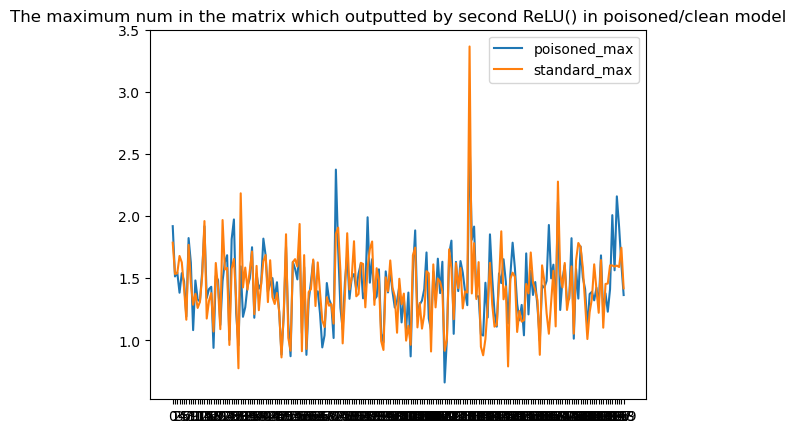

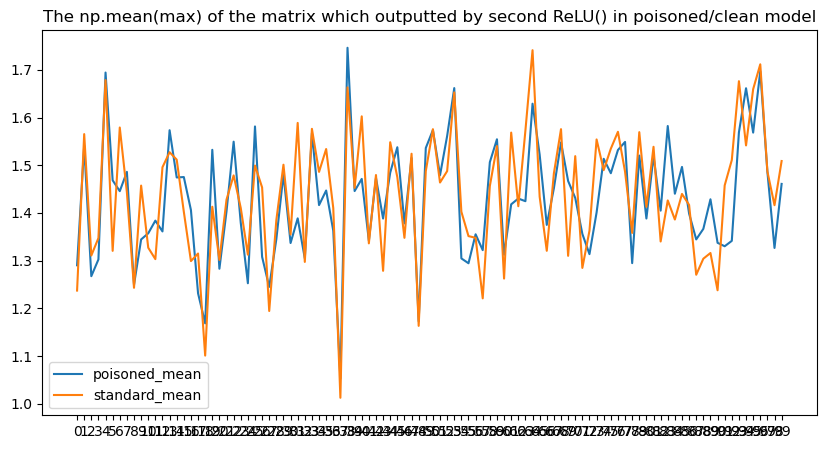

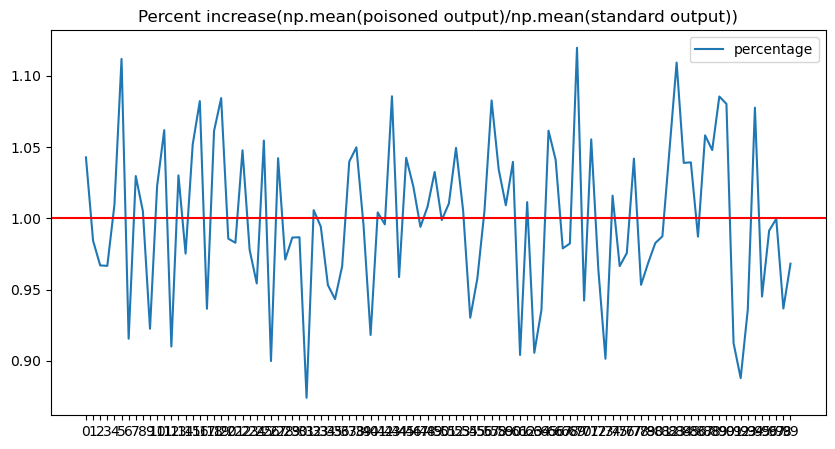

[3.1438909, 3.4636064, 3.3190818, 3.6828175, 3.4455974, 3.6078918, 2.8916528, 3.5882957, 3.0409503, 3.3167918, 3.1082225, 3.5457861, 3.3471076, 3.5871942, 3.4634454, 4.140532, 3.4385543, 3.753429, 3.573988, 3.5367107, 3.2430837, 3.7387664, 3.9392037, 3.7140083, 3.546816, 3.9705648, 3.3982847, 3.717075, 3.5541854, 3.0733984, 3.4846635, 3.932068, 3.6790907, 3.289479, 2.9831266, 3.7324295, 3.270982, 3.6095185, 4.038097, 3.6687007, 3.3560963, 3.4790375, 3.144615, 3.084062, 3.3816078, 3.6239848, 3.3468082, 3.7464817, 3.0693843, 3.6222005, 3.277729, 3.7853851, 3.108705, 4.4302354, 3.5011334, 3.6790617, 3.3527377, 4.2221084, 3.4159515, 3.553708, 3.7297382, 3.5017755, 3.567052, 3.7829182, 3.7814932, 3.8753808, 3.2073667, 3.9969308, 3.1437602, 3.7351732, 3.9544964, 3.8962605, 3.5562444, 3.5436332, 3.2729392, 3.3010283, 3.5033906, 4.1781764, 3.104974, 3.8865688, 3.4249399, 3.771015, 3.140239, 3.50578, 3.4156382, 3.8057125, 3.5740466, 4.1223683, 3.3124192, 3.16657, 3.559196, 3.7480092, 3.26093, 3

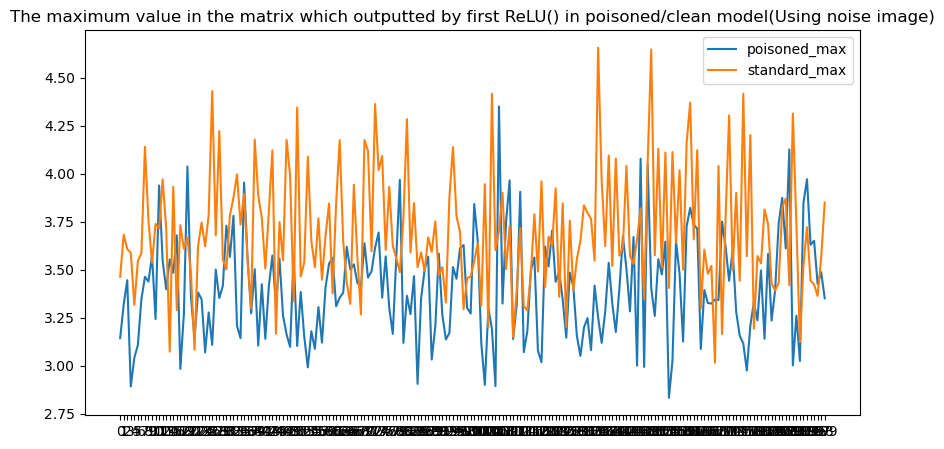

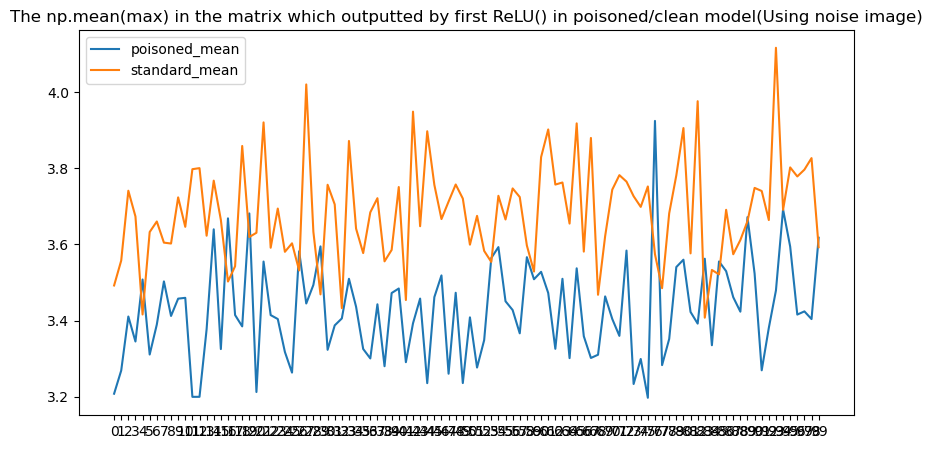

<BarContainer object of 2 artists>

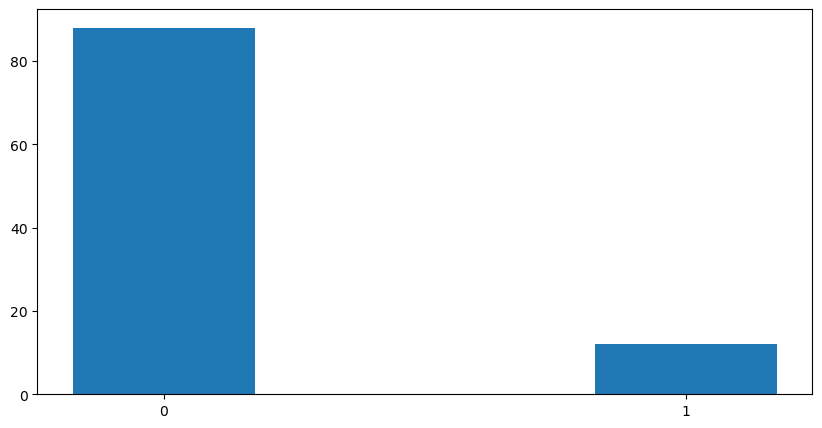

In [3]:
maxList = []
x = 0

for i, y in cleanData:
    x += 1
    i = i.to(device)
    output = poisonedModel(i)
    output_standard = cleanModel(i)
    if x >= 200:
        break

label = np.arange(len(maxList)/2)
poisoned_max = []
standard_max = []
for a in range(len(maxList)):
    if a % 2 == 0:
        poisoned_max.append(maxList[a])
    else:
        standard_max.append(maxList[a])


plt.plot(label, poisoned_max, label="poisoned_max")
plt.plot(label, standard_max, label="standard_max")

plt.title("The maximum num in the matrix which outputted by second ReLU() in poisoned/clean model")
plt.xticks(label)
plt.rcParams["figure.figsize"] = (10, 5)
plt.legend()
plt.show()


#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

number_of_means = 100

poisoned_mean = []
standard_mean = []
for j in range(number_of_means):
    maxList = []
    x = 0
    for i, y in cleanData:
        x += 1
        i = i.to(device)
        output = poisonedModel(i)
        output_standard = cleanModel(i)
        if x >= 5:
            break
    label = np.arange(number_of_means)
    poisoned_max = []
    standard_max = []
    for a in range(len(maxList)):
        if a % 2 == 0:
            poisoned_max.append(maxList[a])
        else:
            standard_max.append(maxList[a])
    
    poisoned_mean.append(np.mean(poisoned_max))
    standard_mean.append(np.mean(standard_max))
    
# =====================================================================
# handle.remove()
# handle_standard.remove()
# =====================================================================


plt.plot(label, poisoned_mean, label="poisoned_mean")
plt.plot(label, standard_mean, label="standard_mean")


plt.title("The np.mean(max) of the matrix which outputted by second ReLU() in poisoned/clean model")
plt.xticks(label)
plt.rcParams["figure.figsize"] = (10, 5)
plt.legend()
plt.show()

percentage = []

for i in range(len(poisoned_mean)):
    percentage.append(poisoned_mean[i]/standard_mean[i])

plt.plot(label, percentage, label="percentage")
plt.axhline(y=1, color='r', linestyle='-')
plt.title("Percent increase(np.mean(poisoned output)/np.mean(standard output))")
plt.xticks(label)
plt.rcParams["figure.figsize"] = (10, 5)
plt.legend()
plt.show()



maxList = []

x = 0

for i, y in NoiseData:
    x += 1
    i = i.to(device)
    output = poisonedModel(i)
    output_standard = cleanModel(i)
    if x >= 200:
        break

print(maxList)

label = np.arange(len(maxList)/2)
poisoned_max = []
standard_max = []
for a in range(len(maxList)):
    if a % 2 == 0:
        poisoned_max.append(maxList[a])
    else:
        standard_max.append(maxList[a])



plt.plot(label, poisoned_max, label="poisoned_max")
plt.plot(label, standard_max, label="standard_max")
print(np.max(poisoned_max))
print(np.max(standard_max))
print(np.max(poisoned_max)/np.max(standard_max))
print(np.mean(poisoned_max))
print(np.mean(standard_max))
print(np.mean(poisoned_max)/np.mean(standard_max))
compare_list = []
for i in range(len(poisoned_max)):
    if poisoned_max[i] > standard_max[i]:
        compare_list.append(1)
    else:
        compare_list.append(0)

stat = Counter(compare_list)
print(stat)


plt.title("The maximum value in the matrix which outputted by first ReLU() in poisoned/clean model(Using noise image)")
plt.xticks(label)
plt.rcParams["figure.figsize"] = (10, 5)
plt.legend()
plt.show()


# repeat same 5 images 100 times.
number_of_means = 100

poisoned_mean = []
standard_mean = []
for j in range(number_of_means):
    maxList = []
    x = 0
    for i, y in NoiseData:
        x += 1
        i = i.to(device)
        output = poisonedModel(i)
        output_standard = cleanModel(i)
        if x >= 5:
            break
    label = np.arange(number_of_means)
    poisoned_max = []
    standard_max = []
    for a in range(len(maxList)):
        if a % 2 == 0:
            poisoned_max.append(maxList[a])
        else:
            standard_max.append(maxList[a])
    
    poisoned_mean.append(np.mean(poisoned_max))
    standard_mean.append(np.mean(standard_max))

handle.remove()
handle_standard.remove()

plt.plot(label, poisoned_mean, label="poisoned_mean")
plt.plot(label, standard_mean, label="standard_mean")


plt.title("The np.mean(max) in the matrix which outputted by first ReLU() in poisoned/clean model(Using noise image)")
plt.xticks(label)
plt.rcParams["figure.figsize"] = (10, 5)
plt.legend()
plt.show()

compare_list = []
for i in range(len(poisoned_mean)):
    if poisoned_mean[i] > standard_mean[i]:
        compare_list.append(1)
    else:
        compare_list.append(0)

stat = Counter(compare_list)

plt.xticks([0, 1])
plt.bar(stat.keys(), stat.values(), width=0.35)